In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions

from linux_qm.src.util import normalize, ind_rxn_map
from linux_qm.src.render import draw_reacting_mapnums, draw_multiple_smi_rdkit, draw_multiple_smi

In [48]:
df = pd.read_excel('../data/slv_amides/TADAM 4AI OPT2c.xlsx', sheet_name='Amides')
# df = pd.read_csv('../data/slv_amides/amide_mapped_training_set.csv')
df.dropna(subset=['acid_smi', 'amine_smi', 'product_smi'], inplace=True)
df.sample(5)

,Reaction,acid_smi,amine_smi,product_smi,Unnamed: 4
25,#111,CC1=C(C(O)=O)C2=CC=CC=C2N1,CC1=CC=C(C=C1)C1=NNC(N)=C1,CC1=C(C(=O)NC2=CC(=NN2)C2=CC=C(C)C=C2)C2=CC=CC...,
8,Trans-#35,O[C@H]1CC[C@@H](CC1)C(O)=O,CC1=CC(N)=NN1,CC1=CC(NC(=O)[C@H]2CC[C@H](O)CC2)=NN1,
0,#17,CC1=C(Cl)C=NN1CC(O)=O,NC1=CC=NC2=CC(Br)=CC=C12,CC1=C(Cl)C=NN1CC(=O)NC1=CC=NC2=CC(Br)=CC=C12,
38,#153,OC(=O)C1=CNC2=CC=C(Br)C=C12,NC1=CC=C2C=NNC2=C1,BrC1=CC=C2NC=C(C(=O)NC3=CC=C4C=NNC4=C3)C2=C1,
22,#100,OC(=O)CC1=C(Cl)C=CC=C1Cl,CC1=CC=C2NC(N)=NC2=C1,CC1=CC=C2NC(NC(=O)CC3=C(Cl)C=CC=C3Cl)=NC2=C1,


In [50]:
df.amine_smi = df.amine_smi.apply(normalize)
df.acid_smi = df.acid_smi.apply(normalize)
df.product_smi = df.product_smi.apply(normalize)
df["rxn_smi"] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi = df.rxn_smi.apply(ind_rxn_map)

[02:48:17] Running LargestFragmentChooser
[02:48:17] Fragment: Nc1ccnc2cc(Br)ccc12
[02:48:17] New largest fragment: Nc1ccnc2cc(Br)ccc12 (19)
[02:48:17] Initializing Normalizer
[02:48:17] Running Normalizer
[02:48:17] Running Uncharger
[02:48:17] Running LargestFragmentChooser
[02:48:17] Fragment: Cc1cc2[nH]ncc2cc1N
[02:48:17] New largest fragment: Cc1cc2[nH]ncc2cc1N (20)
[02:48:17] Initializing Normalizer
[02:48:17] Running Normalizer
[02:48:17] Running Uncharger
[02:48:17] Running LargestFragmentChooser
[02:48:17] Fragment: Cc1c(-c2ccccc2)n[nH]c1N
[02:48:17] New largest fragment: Cc1c(-c2ccccc2)n[nH]c1N (24)
[02:48:17] Initializing Normalizer
[02:48:17] Running Normalizer
[02:48:17] Running Uncharger
[02:48:17] Running LargestFragmentChooser
[02:48:17] Fragment: Nc1cc(-c2ccccc2)n[nH]1
[02:48:17] New largest fragment: Nc1cc(-c2ccccc2)n[nH]1 (21)
[02:48:17] Initializing Normalizer
[02:48:17] Running Normalizer
[02:48:17] Running Uncharger
[02:48:17] Running LargestFragmentChooser
[02:48

[CH3:1][c:2]1[cH:7][c:5]([NH2:6])[nH:4][n:3]1.[CH3:8][n:9]1[cH:16][cH:15][n:14][c:10]1[C:11](=[O:13])O>>[CH3:1][c:2]1[cH:7][c:5]([NH:6][C:11](=[O:13])[c:10]2[n:14][cH:15][cH:16][n:9]2[CH3:8])[n:4][nH:3]1
Reacting Atom Idx: ((0,), (1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 11
Mapped reacting atom: O 0


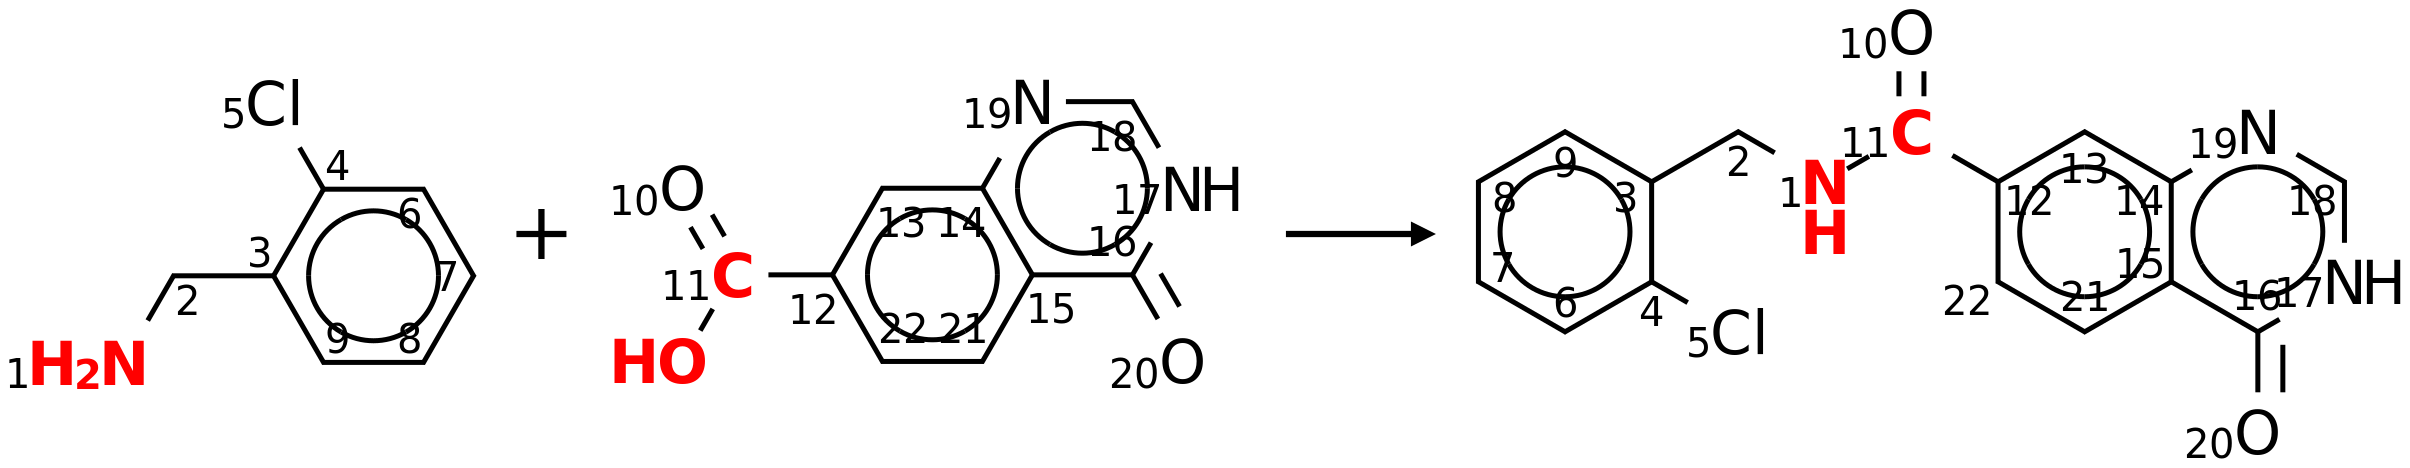

[1, 11, 0]

In [61]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)
draw_reacting_mapnums(df.rxn_smi.sample(1).iat[0])

# SMARTS Amine Descriptor

In [13]:
amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS_v2.csv')
amine_smarts_df

,SMARTS,Description
0,[NH2],primary amine
1,"[NX3;H1,H2]-[c]",N - aromatic carbon
2,"[NX3;H1,H2]-[CH2]",N - CH2
3,"[NX3;H1,H2]-[CH2]-[CH2]",N - (CH2)2
4,"[NX3;H1,H2]-[CH2]-[CH2]-[CH2]",N - (CH2)3
...,...,...
59,"[NX3;H1,H2]-a1anaaa1",N - meta aromatic N in aromatic 6-membered aro...
60,"[NX3;H1,H2]-a1aanaa1",N - para aromatic N in aromatic 6-membered aro...
61,"[NX3;H1,H2]-a1a(-[*])aaaa1",any atom in -orto position across 6-membered a...
62,"[NX3;H1,H2]-a1a(-[*][*])aaaa1",* - * in -orto position across 6-membered aro...


In [14]:
smarts = amine_smarts_df.SMARTS.iat[8]
query = Chem.MolFromSmarts(smarts)
query

def check_query(smarts):
    try:
        Chem.MolFromSmarts(smarts)
        return True
    except:
        return False

amine_smarts_df.SMARTS.apply(check_query).sum() == len(amine_smarts_df)

True

In [15]:
def has_match(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.HasSubstructMatch(query)

def match_atoms(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetSubstructMatch(query)

mol = Chem.MolFromSmiles('Nc1ccccc1')
queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
for query in queries:
    mol.GetSubstructMatch(query)

In [16]:
mask = df.amine_smi.apply(has_match, args=(query,))

(0, 17, 16, 2, 1, 3, 21, 20, 19, 18)
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 24


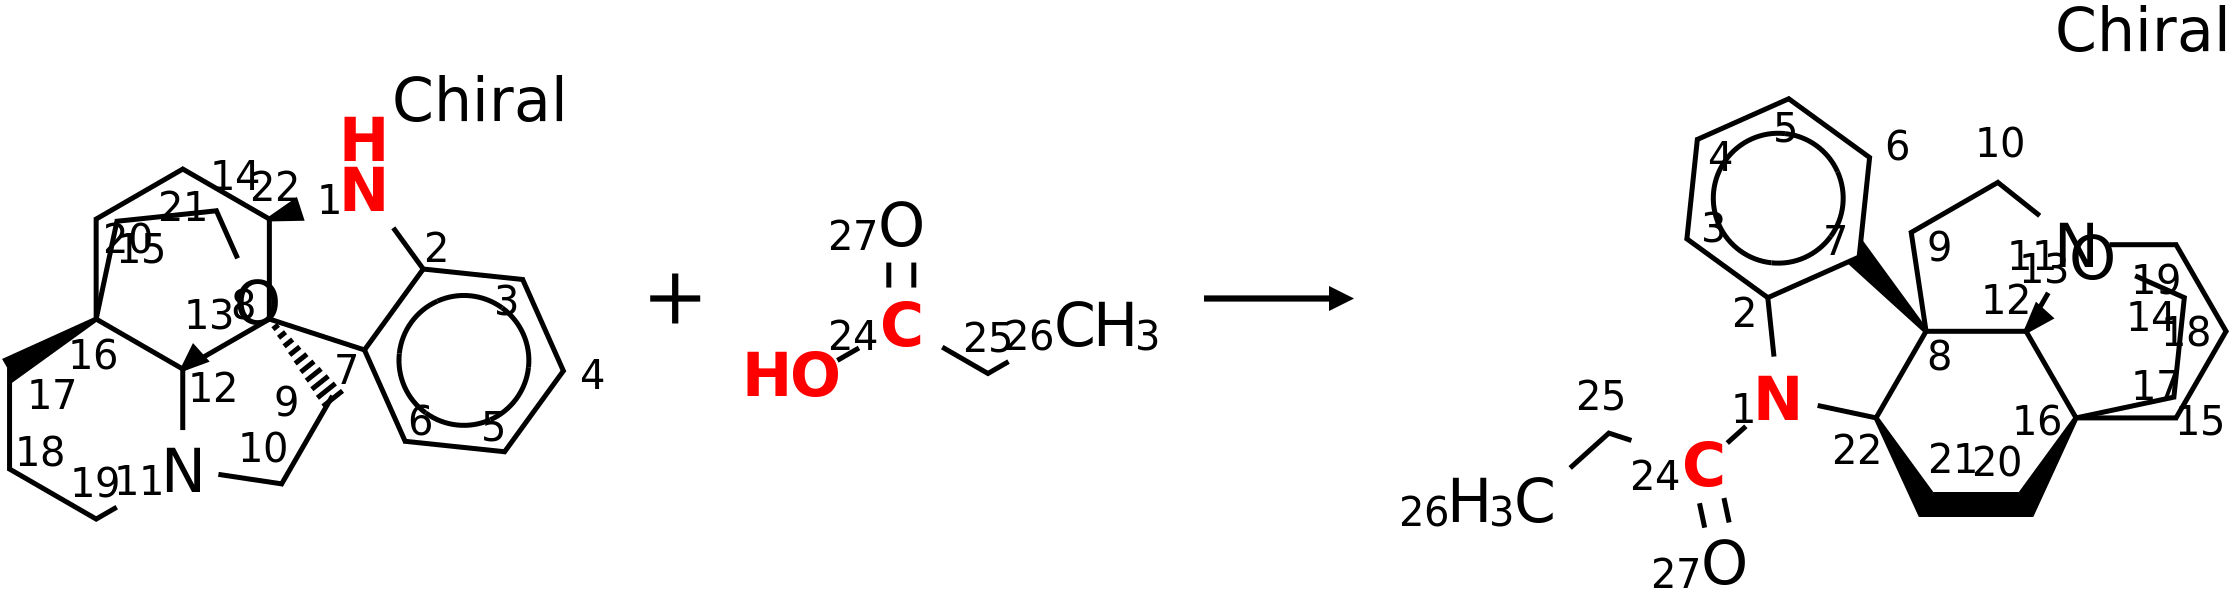

[1, 0, 24]

In [17]:
rxn_smi = df.loc[mask, 'rxn_smi'].sample(1).iat[0]
print(match_atoms(rxn_smi.split('.')[0], query))
draw_reacting_mapnums(rxn_smi)

In [18]:
def match_queries(mol, queries: list, react_atom_id: int):
    size = len(queries)
    result = np.zeros(size, dtype=int)
    for i, query in enumerate(queries):
        result[i] = match_reacting_atom(mol, query, react_atom_id)
    return result

def match_reacting_atom(mol, query, react_atom_id: int):
    try:
        for match_atoms in mol.GetSubstructMatches(query):
            # print('match_atoms:', match_atoms)
            if react_atom_id == match_atoms[0]:
                return True
        return False
    except Exception as e:
        print(f"{type(e).__name__}: {e} \n for query: {Chem.MolToSmarts(query)}\n for smiles: {Chem.MolToSmiles(mol)}")

In [19]:
queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
# queries = amine_smarts_df.SMARTS.apply(load_query)

def update_props(mol):
    mol.UpdatePropertyCache()
    Chem.GetSymmSSSR(mol)

def smarts_descriptor(rxn_smi, queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    return match_queries(amine, queries, react_nitrogen)

smarts_descriptor(rxn_smi, queries)

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [20]:
query = queries[32]
smarts_descriptor(rxn_smi, [query])

array([0])

# SMARTS Acid descriptor

In [27]:
# acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS_v2.csv')
acid_smarts_df

,SMARTS,Description
0,[OH]-[C](=[O])-[c],CA - aromatic carbon
1,[OH]-[C](=[O])-[CH2],CA - CH2
2,[OH]-[C](=[O])-[CH2]-[CH2],CA - (CH2)2
3,[OH]-[C](=[O])-[CH2]-[CH2]-[CH2],CA - (CH2)3
4,[OH]-[C](=[O])-[CH1]([*])[*],CA - izopropyl scaffold
...,...,...
59,[OH]-[C](=[O])-a1anaaa1,N - meta aromatic N in aromatic 6-membered aro...
60,[OH]-[C](=[O])-a1aanaa1,N - para aromatic N in aromatic 6-membered aro...
61,[OH]-[C](=[O])-a1a(-[*])aaaa1,any atom in -orto position across 6-membered a...
62,[OH]-[C](=[O])-a1a(-[*][*])aaaa1,* - * in -orto position across 6-membered aro...


In [28]:
queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

[O&H1]-C(=O)-C=C
469


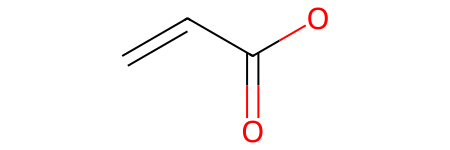

In [29]:
query = queries[48]
query = queries[51]
query = queries[6]

mask = df.acid_smi.apply(has_match, args=(query,))
print(Chem.MolToSmarts(query))
print(mask.sum())

query

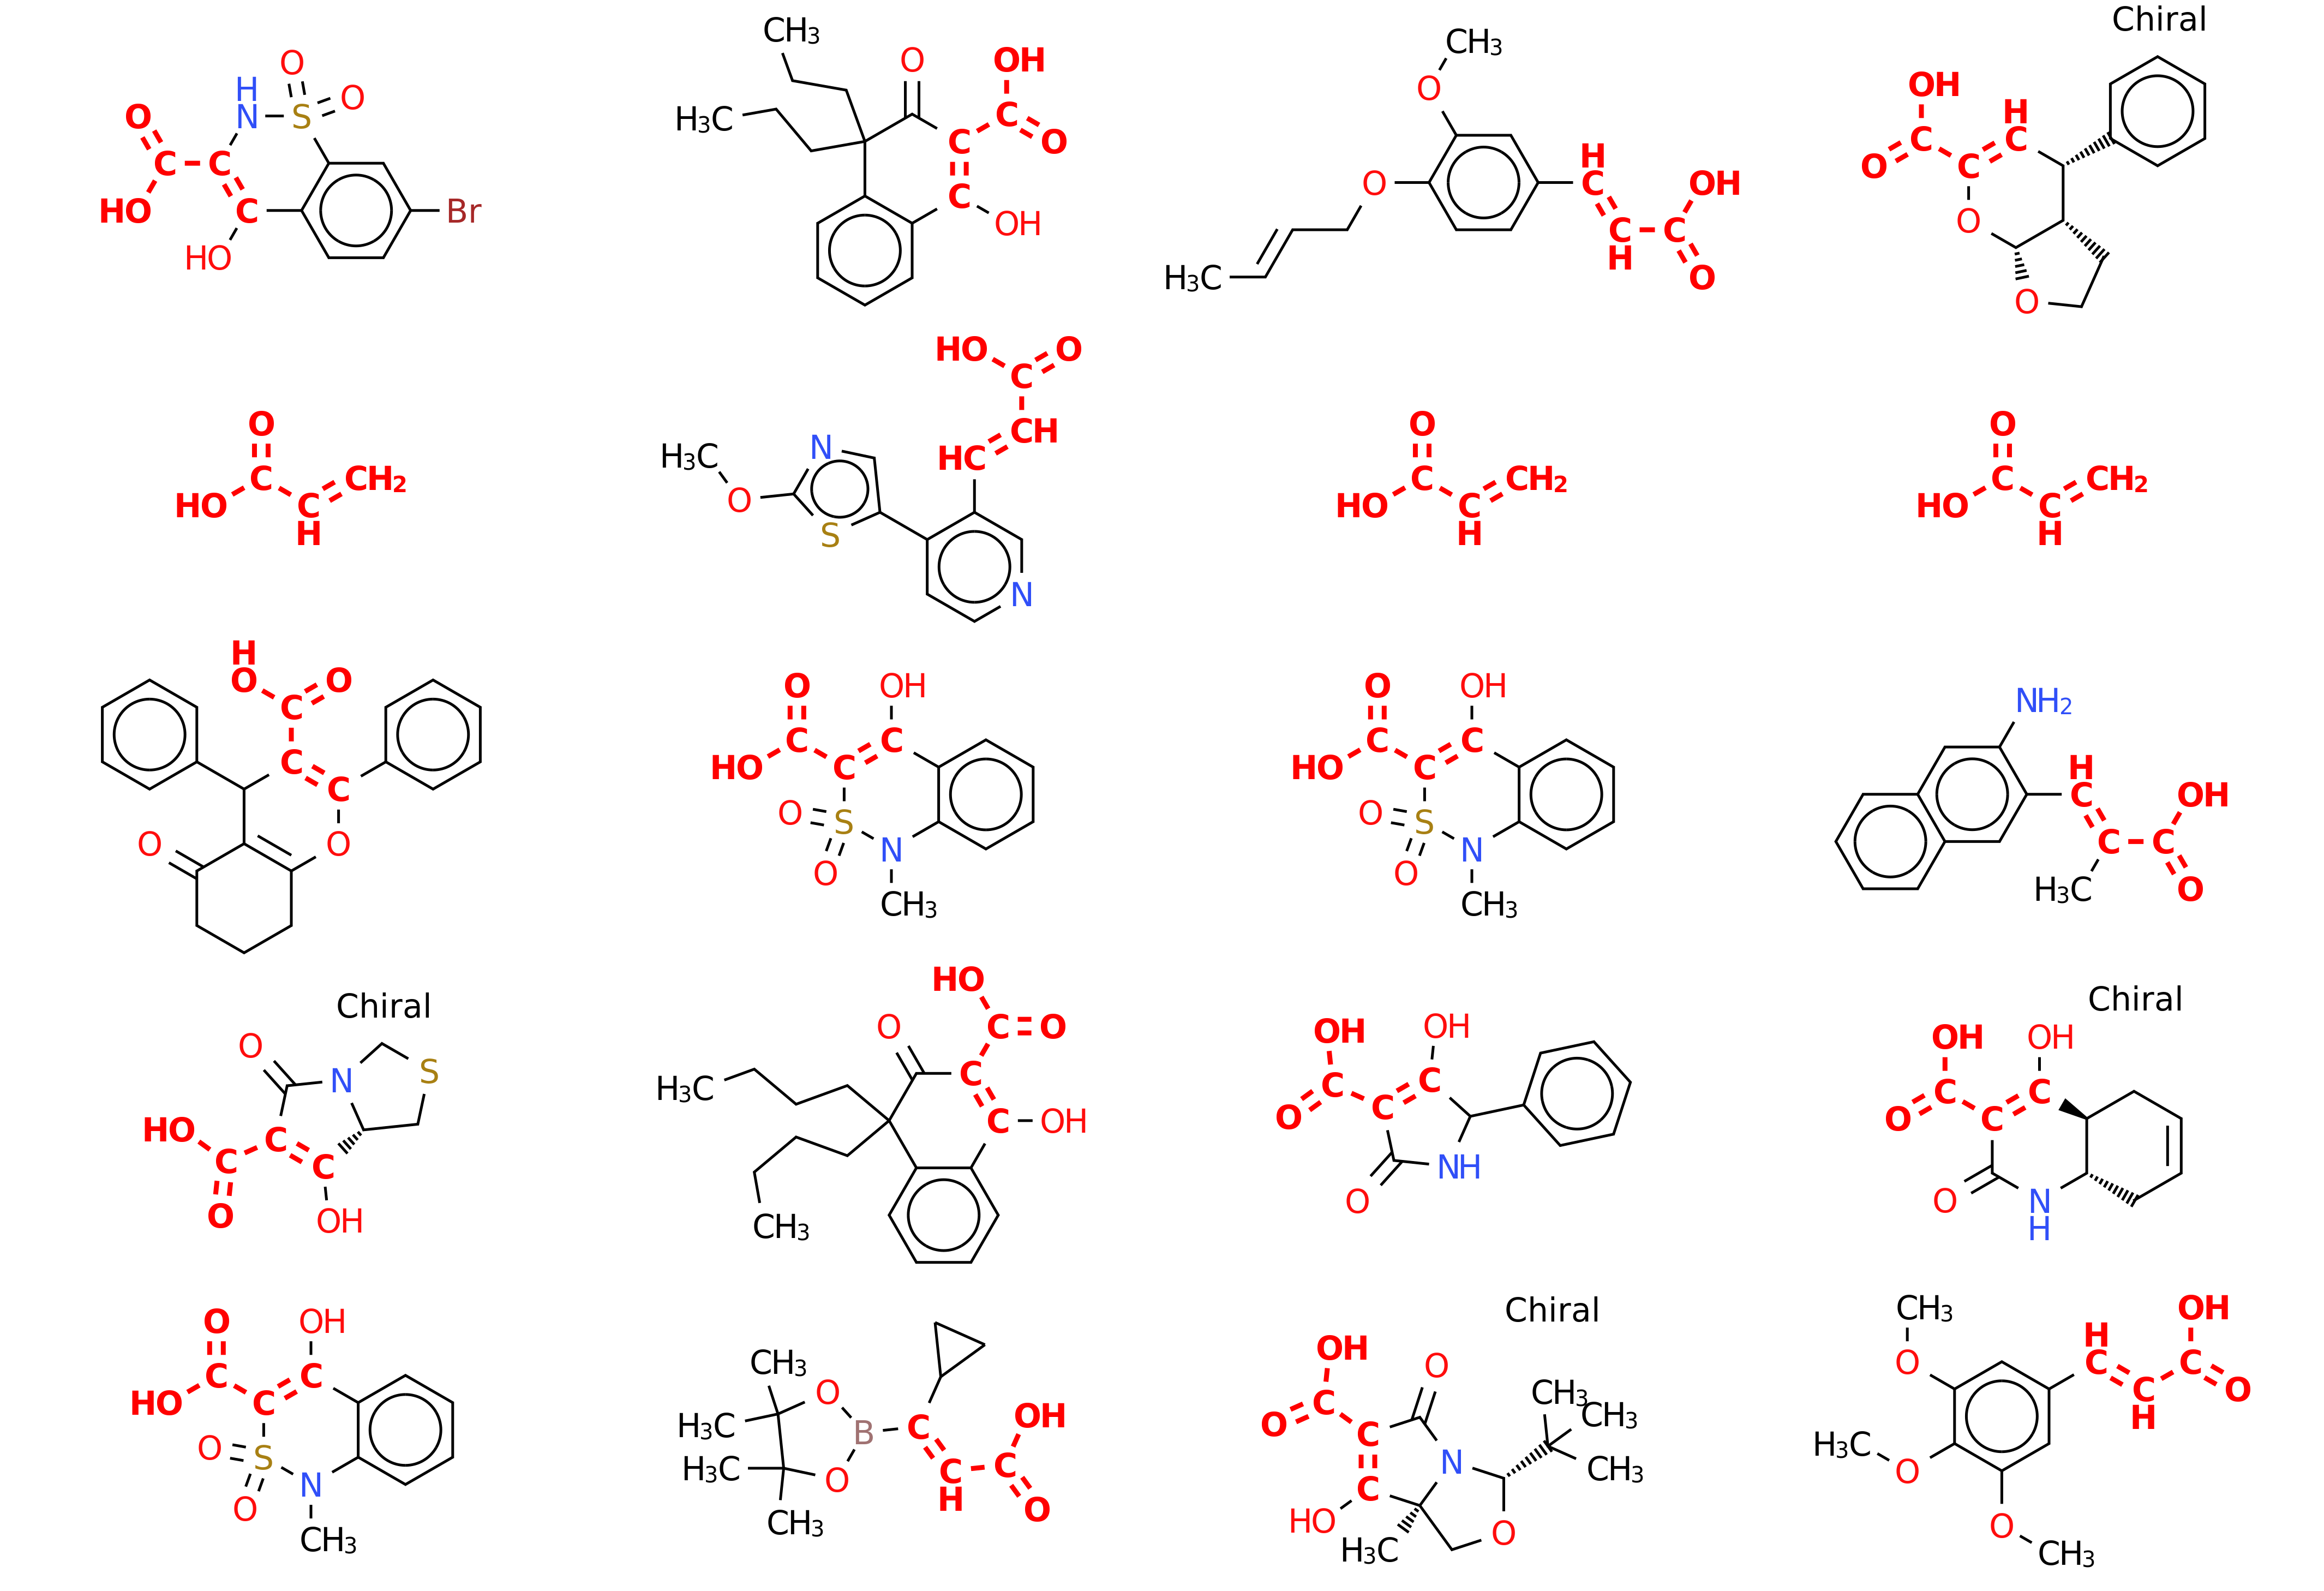

In [30]:
draw_multiple_smi(df.loc[mask, 'acid_smi'].sample(20), highlight_smi=Chem.MolToSmarts(query))

In [25]:
count = {}

for query in tqdm(queries):
    mask = df.acid_smi.apply(has_match, args=(query,))
    count[Chem.MolToSmarts(query)] = mask.sum()

count

 70%|███████   | 45/64 [00:26<00:11,  1.72it/s]


ArgumentError: Python argument types in
    Mol.HasSubstructMatch(Mol, NoneType)
did not match C++ signature:
    HasSubstructMatch(RDKit::ROMol self, RDKit::MolBundle query, RDKit::SubstructMatchParameters params=True)
    HasSubstructMatch(RDKit::ROMol self, RDKit::ROMol query, RDKit::SubstructMatchParameters params)
    HasSubstructMatch(RDKit::ROMol self, RDKit::MolBundle query, bool recursionPossible=True, bool useChirality=False, bool useQueryQueryMatches=False)
    HasSubstructMatch(RDKit::ROMol self, RDKit::ROMol query, bool recursionPossible=True, bool useChirality=False, bool useQueryQueryMatches=False)

In [31]:
def get_first_ratom_acid(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    react_atoms_ids = rxn.GetReactingAtoms()
    react_carbon = react_atoms_ids[1][1]
    return acid.GetAtomWithIdx(react_carbon).GetSymbol()

o_mask = df.rxn_smi.apply(get_first_ratom_acid) == 'O'

Reacting Atom Idx: ((4,), (8, 10))
Mapped reacting atom: N 14
Mapped reacting atom: C 22
Mapped reacting atom: O 0


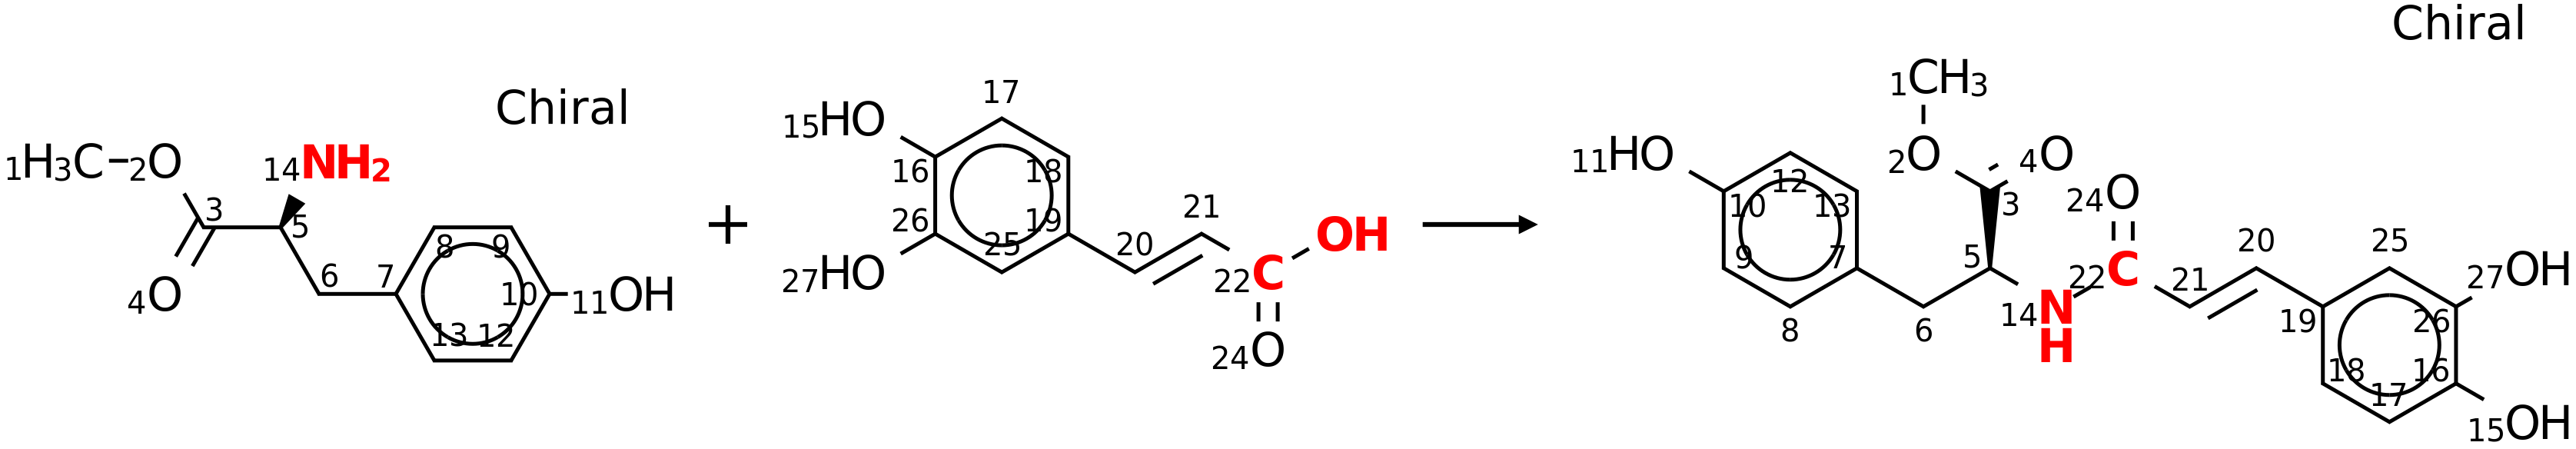

[14, 22, 0]

In [32]:
draw_reacting_mapnums(df[o_mask].sample(1).rxn_smi.iat[0])

In [33]:
def find_acid_carbon(acid, react_atoms: list):
    for i in react_atoms:
        if acid.GetAtomWithIdx(i).GetSymbol() == 'C':
            return i

In [36]:
def smarts_descriptor(rxn_smi, amine_queries: list, acid_queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    react_carbon = find_acid_carbon(acid, react_atoms_ids[1])
    amine_descr = match_queries(amine, amine_queries, react_nitrogen)
    acid_descr = match_queries(acid, acid_queries, react_carbon)
    return np.hstack([amine_descr, acid_descr])

amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
from rdkit import Chem
import pandas as pd

from linux_qm.desc.smarts import smarts_descriptor

rxn_smi = "[NH2:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1.O[C:11](=[O:15])[CH2:12][C:13]#[N:14]>>[N:14]#[C:13][CH2:12][C:11](=[O:15])[NH:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1"

amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS_v2.csv')
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS_v2.csv')
amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

(array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [63]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

ProgressBar().register()

ddf = dd.from_pandas(df.rxn_smi, npartitions=128)

res = ddf.apply(smarts_descriptor,
                args=(amine_queries, acid_queries,),
                meta=ddf).compute(scheduler='threads')

df[['amine_fp', 'acid_fp']] = pd.DataFrame(res.tolist())

[########################################] | 100% Completed | 313.13 ms
[########################################] | 100% Completed | 314.02 ms


In [41]:
# df.to_pickle('../data/slv_amides/amides_train_smarts_fp_v2.pkl')

In [64]:
df.to_pickle('../data/slv_amides/TADAM_4AI_OPT2c_smarts_fp_v2.pkl')

# Correlation

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_pickle('../data/slv_amides/amides_train_smarts_fp_v2.pkl')
df

In [ ]:
fp = np.vstack(df.amine_fp)
fp

In [ ]:
corr_matr = np.corrcoef(fp.T)
corr_matr

In [ ]:
row_idx, col_idx = np.triu_indices(corr_matr.shape[0], k=1)

In [ ]:
corr_matr[row_idx, col_idx]

In [ ]:
corr = pd.DataFrame(np.abs(np.vstack([row_idx, col_idx, corr_matr[row_idx, col_idx]]).T), columns=['row_idx', 'col_idx', 'corr'])
corr.row_idx = corr.row_idx.astype(int)
corr.col_idx = corr.col_idx.astype(int)
corr = corr.sort_values(by='corr', ascending=False)
corr

In [ ]:
amine_smarts_df.SMARTS

In [ ]:
corr.row_idx = corr.row_idx.apply(lambda x: amine_smarts_df.SMARTS.iat[x])
corr.col_idx = corr.col_idx.apply(lambda x: amine_smarts_df.SMARTS.iat[x])

In [ ]:
corr